# <center> <b> <font color='blue'> BITCOIN PREDICTION </center> </b> </font>

## <font color='#154360'> Table of Contents </font>

1. [Problem Statement](#1)
2. [Setup](#2)
3. [Helper Functions](#3)
4. [Loading data, visualization](#4)
5. [Pre-processing](#5)
6. [Modeling Experiments](#6) <br>
    6.0. [Baseline (Naive Forecast)](#6.0) <br>
    6.1. [Dense Model (window size = 7, horizon = 1)](#6.1) <br>
    6.2. [Dense Model (window size = 30, horizon = 1)](#6.2) <br>
    6.3. [Dense Model (window size = 30, horizon = 7)](#6.3) <br>
    6.4. [Conv1D](#6.4) <br>
    6.5. [LSTM](#6.5) <br>
    6.6. [Ensemble](#6.6) <br>
    6.7. [Comparing results](#6.7)
7. [References](#References) <br>


<a name="1"></a>
## <font color='#1a5276'> <b> 1. Problem Statement </font> </b>

We're going to be building a series of models in an attempt to predict the price of Bitcoin. 

<a name="2"></a>
## <font color='#1a5276'> <b> 2. Setup </font> </b>

In [4]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import layers
import os
from dataclasses import dataclass

In [5]:
import logging
tf.get_logger().setLevel(logging.ERROR)

In [6]:
# Class for storing data (for storing some default values)
@dataclass
class G:
    WINDOW_SIZE = 7
    HORIZON = 1
    BATCH_SIZE = 32

<a name="3"></a>
## <font color='#1a5276'> <b> 3. Helper Functions </font> </b>

### Plots

In [7]:
def plot_dataframe(dataframe, title, ylabel, figsize=(8, 5)):
    dataframe.plot(figsize=figsize)
    plt.ylabel(ylabel)
    plt.title(title, fontsize=14)
    plt.legend(fontsize=12)
    
    
def plot_train_vs_test(X_train, y_train, X_test, y_test, title, ylabel, xlabel, figsize=(8,5)):
    """
    X_train: np_array
    y_train: np_array
    ....
    """
    plt.figure(figsize=figsize)
    plt.scatter(X_train, y_train, s=5, label="Train data")
    plt.scatter(X_test, y_test, s=5, label="Test data")
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend(fontsize=12)
    plt.show()
    
    
# Create a function to plot time series data
def plot_time_series(timesteps, values, format='.', start=0, end=None, label=None):
    """
    Plots a timesteps (a series of points in time) against values (a series of values across timesteps).

    Parameters
    ---------
    timesteps : array of timesteps
    values : array of values across time
    format : style of plot, default "."
    start : where to start the plot (setting a value will index from start of timesteps & values)
    end : where to end the plot (setting a value will index from end of timesteps & values)
    label : label to show on plot of values
    """
    # Plot the series
    plt.plot(timesteps[start:end], values[start:end], format, label=label)
    plt.xlabel("Time")
    plt.ylabel("BTC Price")
    if label:
        plt.legend(fontsize=14) # make label bigger
    plt.grid(True)
    
    
    """
    Usage
        plt.figure(figsize=(10, 7))
        plot_time_series(timesteps=X_train, values=y_train, label="Train data")
        plot_time_series(timesteps=X_test, values=y_test, label="Test data")
    """

    
    
# true values vs forecast
def plot_comparisson(timesteps, true_values, forecast_values , label_preds, offset=300, figsize=(7, 4)):
    plt.figure(figsize=figsize)
    # Account for the test_window offset and index into test_labels to ensure correct plotting
    plot_time_series(timesteps=timesteps, values=true_values, start=offset, label="Test_data")
    plot_time_series(timesteps=timesteps, values=forecast_values, start=offset, format="-", label=label_preds)
    
    
# plot history
def plot_history(history):
    # Create a figure with two subplots
    plt.figure(figsize=(12, 5))

    # Plot training & validation loss
    plt.subplot(1, 2, 1)  # One row, two columns, first subplot
    plt.plot(history.history['loss'], label='Training Loss ')
    if 'val_loss' in history.history:
        plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(loc='upper right')


    # Adjust layout
    plt.tight_layout()
    plt.show()

### Windowing dataset


We've got to window our time series.

Why do we window?

Windowing is a method to turn a time series dataset into a **supervised learning problem**. 

In other words, we want to use windows of the past to predict the future.

For example for a univariate time series, windowing for one week (`window=7`) to predict the next single value (`horizon=1`) might look like:

```
Window for one week (univariate time series)

[0, 1, 2, 3, 4, 5, 6] -> [7]
[1, 2, 3, 4, 5, 6, 7] -> [8]
[2, 3, 4, 5, 6, 7, 8] -> [9]
```

Or for the price of Bitcoin, it'd look like:

```
Window for one week with the target of predicting the next day (Bitcoin prices)

[123.654, 125.455, 108.584, 118.674, 121.338, 120.655, 121.795] -> [123.033]
[125.455, 108.584, 118.674, 121.338, 120.655, 121.795, 123.033] -> [124.049]
[108.584, 118.674, 121.338, 120.655, 121.795, 123.033, 124.049] -> [125.961]
```

Let's build some functions which take in a univariate time series and turn it into windows and horizons of specified sizes.

Now we'll write a function to take in an array and turn it into a window and horizon.

In [8]:
# Create function to label windowed data
def get_labelled_windows(x, horizon=1):
  """
  Creates labels for windowed dataset.

  E.g. if horizon=1 (default)
  Input: [1, 2, 3, 4, 5, 6] -> Output: ([1, 2, 3, 4, 5], [6])
  """
  return x[:, :-horizon], x[:, -horizon:]

In [9]:
# Test out the window labelling function with window_size=7 and horizon=1
test_window, test_label = get_labelled_windows(tf.expand_dims(tf.range(8)+1, axis=0), horizon=1)
print(f"Window: {tf.squeeze(test_window).numpy()} -> Label: {tf.squeeze(test_label).numpy()}")

Window: [1 2 3 4 5 6 7] -> Label: 8


Now we need a way to make windows for an entire time series.

We could do this with Python for loops, however, for large time series, that'd be quite slow.

To speed things up, we'll leverage [NumPy's array indexing](https://numpy.org/doc/stable/reference/arrays.indexing.html).

Let's write a function which:
1. Creates a window step of specific window size, for example: `[[0, 1, 2, 3, 4, 5, 6, 7]]`
2. Uses NumPy indexing to create a 2D of multiple window steps, for example: 
```
[[0, 1, 2, 3, 4, 5, 6, 7],
 [1, 2, 3, 4, 5, 6, 7, 8],
 [2, 3, 4, 5, 6, 7, 8, 9]]
```
3. Uses the 2D array of multuple window steps to index on a target series
4. Uses the `get_labelled_windows()` function we created above to turn the window steps into windows with a specified horizon

> 📖 **Resource:** The function created below has been adapted from Syafiq Kamarul Azman's article [*Fast and Robust Sliding Window Vectorization with NumPy*](https://towardsdatascience.com/fast-and-robust-sliding-window-vectorization-with-numpy-3ad950ed62f5).

In [10]:
# Create function to view NumPy arrays as windows 
def make_windows(x, window_size=7, horizon=1):
    """
    Turns a 1D array into a 2D array of sequential windows of window_size.
    """
    # 1. Create a window of specific window_size (add the horizon on the end for later labelling)
    window_step = np.expand_dims(np.arange(window_size+horizon), axis=0)
    # print(f"Window step:\n {window_step}")

    # 2. Create a 2D array of multiple window steps (minus 1 to account for 0 indexing)
    window_indexes = window_step + np.expand_dims(np.arange(len(x)-(window_size+horizon-1)), axis=0).T # create 2D array of windows of size window_size
    # print(f"Window indexes:\n {window_indexes[:3], window_indexes[-3:], window_indexes.shape}")

    # 3. Index on the target array (time series) with 2D array of multiple window steps
    windowed_array = x[window_indexes]

    # 4. Get the labelled windows
    windows, labels = get_labelled_windows(windowed_array, horizon=horizon)

    return windows, labels

> 🔑 **Note:** You can find a function which achieves similar results to the ones we implemented above at [`tf.keras.preprocessing.timeseries_dataset_from_array()`](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/timeseries_dataset_from_array). Just like ours, it takes in an array and returns a windowed dataset. It has the benefit of returning data in the form of a tf.data.Dataset instance (we'll see how to do this with our own data later).

### Train/Test split

In [11]:
# Make the train/test splits
def make_train_test_splits(windows, labels, test_split=0.2):
    """
    Splits matching pairs of windows and labels into train and test splits.
    """
    split_size = int(len(windows) * (1-test_split)) # this will default to 80% train/20% test
    train_windows = windows[:split_size]
    train_labels = labels[:split_size]
    test_windows = windows[split_size:]
    test_labels = labels[split_size:]
    return train_windows, test_windows, train_labels, test_labels

### Make a modelling checkpoint


Because our model's performance will fluctuate from experiment to experiment, we'll want to make sure we're comparing apples to apples.

What I mean by this is in order for a fair comparison, we want to compare each model's best performance against each model's best performance.

For example, if `model_1` performed incredibly well on epoch 55 but its performance fell off toward epoch 100, we want the version of the model from epoch 55 to compare to other models rather than the version of the model from epoch 100.

And the same goes for each of our other models: compare the best against the best.

To take of this, we'll implement a [`ModelCheckpoint`](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/ModelCheckpoint) callback.

The `ModelCheckpoint` callback will monitor our model's performance during training and save the best model to file by setting `save_best_only=True`.

That way when evaluating our model we could restore its best performing configuration from file.

> 🔑 **Note:** Because of the size of the dataset (smaller than usual), you'll notice our modelling experiment results fluctuate quite a bit during training (hence the implementation of the `ModelCheckpoint` callback to save the best model).

Because we're going to be running multiple experiments, it makes sense to keep track of them by saving models to file under different names.

To do this, we'll write a small function to create a `ModelCheckpoint` callback which saves a model to specified filename.

In [12]:
# Create a function to implement a ModelCheckpoint callback with a specific filename 
def create_model_checkpoint(model_name, save_path="model_experiments"):
  return tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(save_path, model_name), # create filepath to save model
                                            verbose=0, # only output a limited amount of text
                                            save_best_only=True) # save only the best model to file

### Predictions

In [13]:
# wrong way!!!
# This way of making predictions is not correct, but it can be useful for a quick comparison of the models.
def make_preds(model, input_data):
  """
  Uses model to make predictions on input_data.

  Parameters
  ----------
  model: trained model 
  input_data: windowed input data (same kind of data model was trained on)

  Returns model predictions on input_data.
  """
  forecast = model.predict(input_data)
  return tf.squeeze(forecast) # return 1D array of predictions

#### Right way to make predictions

<img src='images/preds.png'/>
*Example flow chart representing the loop we're about to create for making forecasts. Not pictured: retraining a forecasting model every time a forecast is made & new data is acquired. For example, if you're predicting the price of Bitcoin daily, you'd want to retrain your model every day, since each day you're going to have a new data point to work with.*

Alright, let's create a function which returns `INTO_FUTURE` forecasted values using a trained model.

To do so, we'll build the following steps:
1. Function which takes as input: 
  * a list of values (the Bitcoin historical data)
  * a trained model (such as `model_9`)
  * a window into the future to predict (our `INTO_FUTURE` variable)
  * the window size a model was trained on (`WINDOW_SIZE`) - the model can only predict on the same kind of data it was trained on
2. Creates an empty list for future forecasts (this will be returned at the end of the function) and extracts the last `WINDOW_SIZE` values from the input values (predictions will start from the last `WINDOW_SIZE` values of the training data)
3. Loop `INTO_FUTURE` times making a prediction on `WINDOW_SIZE` datasets which update to remove the first the value and append the latest prediction 
  * Eventually future predictions will be made using the model's own previous predictions as input.
  
  

  

In [14]:
def make_future_forecast(model, initial_window, into_future, window_size=G.WINDOW_SIZE, verbose=False) -> np.ndarray:
    """
    Makes future forecasts `into_future` steps after initial_window ends.
    
    Parameters:
    - model: Trained forecasting model.
    - initial_window: Starting window of values to make future predictions.
    - into_future: Number of future steps to predict.
    - window_size: Size of the window that the model expects.
    
    Returns:
    - NumPy array of predictions of shape (into_future, horizon).
    """
    future_forecast = []  # List to store all predictions
    last_window = initial_window  # Initialize with the initial window
    
    for step in range(into_future):
        # Make a prediction on the current window
        future_pred = model.predict(tf.expand_dims(last_window, axis=0), verbose=0)
        
        # Log predictions if verbose is True
        if verbose:
            print(f"Predicting on: \n {last_window} -> Prediction: {tf.squeeze(future_pred).numpy()}\n")
        
        # Append the current prediction (horizon) to future_forecast
        future_forecast.append(tf.squeeze(future_pred).numpy())
        
        # Update last_window by adding the latest prediction, keeping the window size
        last_window = np.append(last_window, future_pred[0][0])[-window_size:]

    # Convert the list of predictions to a NumPy array with shape (into_future, horizon)
    return np.array(future_forecast)


> As it is, the `make_future_forecasts()` function skips the retraining of a model part.

### Evaluation

In [15]:
# MASE implemented courtesy of sktime - https://github.com/alan-turing-institute/sktime/blob/ee7a06843a44f4aaec7582d847e36073a9ab0566/sktime/performance_metrics/forecasting/_functions.py#L16
def mean_absolute_scaled_error(y_true, y_pred):
  """
  Implement MASE (assuming no seasonality of data).
  """
  mae = tf.reduce_mean(tf.abs(y_true - y_pred))

  # Find MAE of naive forecast (no seasonality)
  mae_naive_no_season = tf.reduce_mean(tf.abs(y_true[1:] - y_true[:-1])) # our seasonality is 1 day (hence the shifting of 1 day)

  return mae / mae_naive_no_season



# single horizon
def evaluate_preds(y_true, y_pred):
    # Make sure float32 (for metric calculations)
    y_true = tf.cast(y_true, dtype=tf.float32)
    y_pred = tf.cast(y_pred, dtype=tf.float32)

    # Calculate various metrics
    mae = tf.keras.metrics.mean_absolute_error(y_true, y_pred)
    mse = tf.keras.metrics.mean_squared_error(y_true, y_pred) # puts and emphasis on outliers (all errors get squared)
    rmse = tf.sqrt(mse)
    mape = tf.keras.metrics.mean_absolute_percentage_error(y_true, y_pred)
    mase = mean_absolute_scaled_error(y_true, y_pred)

    return {"mae": mae.numpy(),
          "mse": mse.numpy(),
          "rmse": rmse.numpy(),
          "mape": mape.numpy(),
          "mase": mase.numpy()}


# multi-step horizon
def evaluate_preds_generalized(y_true, y_pred):
  # Make sure float32 (for metric calculations)
  y_true = tf.cast(y_true, dtype=tf.float32)
  y_pred = tf.cast(y_pred, dtype=tf.float32)

  # Calculate various metrics
  mae = tf.keras.metrics.mean_absolute_error(y_true, y_pred)
  mse = tf.keras.metrics.mean_squared_error(y_true, y_pred)
  rmse = tf.sqrt(mse)
  mape = tf.keras.metrics.mean_absolute_percentage_error(y_true, y_pred)
  mase = mean_absolute_scaled_error(y_true, y_pred)

  # Account for different sized metrics (for longer horizons, reduce to single number)
  if mae.ndim > 0: # if mae isn't already a scalar, reduce it to one by aggregating tensors to mean
    mae = tf.reduce_mean(mae)
    mse = tf.reduce_mean(mse)
    rmse = tf.reduce_mean(rmse)
    mape = tf.reduce_mean(mape)
    mase = tf.reduce_mean(mase)

  return {"mae": mae.numpy(),
          "mse": mse.numpy(),
          "rmse": rmse.numpy(),
          "mape": mape.numpy(),
          "mase": mase.numpy()}


<a name="4"></a>
## <font color='#1a5276'> <b> 4. Loading data, visualization</font> </b>

### Get data

We're going to get the prices of Bitcoin from 01 October 2013 to 18 May 2021.

In [16]:
# Download Bitcoin historical data from GitHub 
# Note: you'll need to select "Raw" to download the data in the correct format
#!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv 

In [17]:
!ls

'10_time_series_forecasting_in_tensorflow (1).ipynb'   images
'Bitcoin Prediction.ipynb'			       model_experiments
 BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv


### Importing time series data with pandas


Because our data is in **CSV (comma separated values)** format, we'll use the pandas [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.read_csv.html) function.

And because our data has a date component, we'll tell pandas to parse the dates using the `parse_dates` parameter passing it the name of our date column ("Date").

In [18]:
# Parse dates and set date column to index
df = pd.read_csv("BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv", 
                 parse_dates=["Date"], 
                 index_col=["Date"]) # parse the date column (tell pandas column 1 is a datetime)
df.head()

,Currency,Closing Price (USD),24h Open (USD),24h High (USD),24h Low (USD)
Date,,,,,
2013-10-01,BTC,123.65499,124.30466,124.75166,122.56349
2013-10-02,BTC,125.45500,123.65499,125.75850,123.63383
2013-10-03,BTC,108.58483,125.45500,125.66566,83.32833
2013-10-04,BTC,118.67466,108.58483,118.67500,107.05816
2013-10-05,BTC,121.33866,118.67466,121.93633,118.00566


In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2787 entries, 2013-10-01 to 2021-05-18
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Currency             2787 non-null   object 
 1   Closing Price (USD)  2787 non-null   float64
 2   24h Open (USD)       2787 non-null   float64
 3   24h High (USD)       2787 non-null   float64
 4   24h Low (USD)        2787 non-null   float64
dtypes: float64(4), object(1)
memory usage: 130.6+ KB


We can see that there are no missing values.

Because we told pandas to parse the date column and set it as the index, its not in the list of columns.

In [20]:
# How many samples do we have?
len(df)

2787

We've collected the historical price of Bitcoin for the past ~8 years but there's only 2787 total samples.

This is something you'll run into with time series data problems. Often, the number of samples isn't as large as other kinds of data.

For example, collecting one sample at different time frames results in:

| 1 sample per timeframe | Number of samples per year |
| ----- | ----- |
| Second | 31,536,000 |
| Hour | 8,760 |
| Day | 365 |
| Week | 52 |
| Month | 12 |

To simplify, let's remove some of the columns from our data so we're only left with a date index and the closing price.

In [21]:
# Only want closing price for each day 
bitcoin_prices = pd.DataFrame(df["Closing Price (USD)"]).rename(columns={"Closing Price (USD)": "Price"})
bitcoin_prices.head()

,Price
Date,
2013-10-01,123.65499
2013-10-02,125.45500
2013-10-03,108.58483
2013-10-04,118.67466
2013-10-05,121.33866


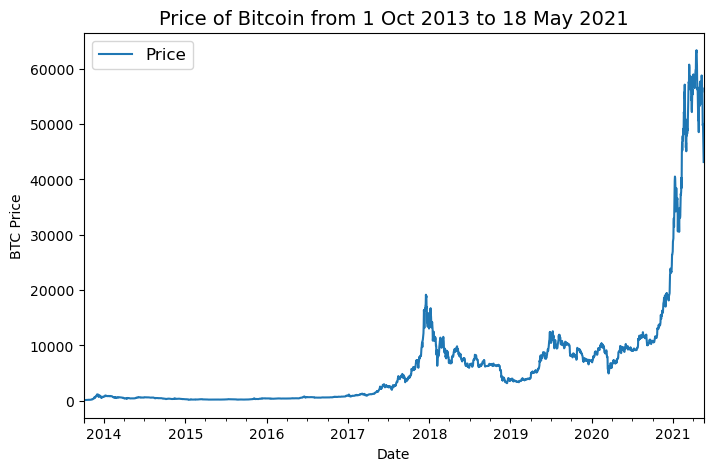

In [22]:
plot_dataframe(bitcoin_prices, "Price of Bitcoin from 1 Oct 2013 to 18 May 2021", "BTC Price")

Woah, looks like it would've been a good idea to buy Bitcoin back in 2014.

### Plot Train/Test Split

Let's turn our DataFrame index and column into NumPy arrays.

In [23]:
# Get bitcoin date array
timesteps = bitcoin_prices.index.to_numpy()
prices = bitcoin_prices["Price"].to_numpy()

timesteps[:5], prices[:5]

(array(['2013-10-01T00:00:00.000000000', '2013-10-02T00:00:00.000000000',
        '2013-10-03T00:00:00.000000000', '2013-10-04T00:00:00.000000000',
        '2013-10-05T00:00:00.000000000'], dtype='datetime64[ns]'),
 array([123.65499, 125.455  , 108.58483, 118.67466, 121.33866]))

In [24]:
# Create train and test splits the right way for time series data
split_size = int(0.8 * len(prices)) # 80% train, 20% test

# Create train data splits (everything before the split)
X_train, y_train = timesteps[:split_size], prices[:split_size]

# Create test data splits (everything after the split)
X_test, y_test = timesteps[split_size:], prices[split_size:]

len(X_train), len(X_test), len(y_train), len(y_test)

(2229, 558, 2229, 558)

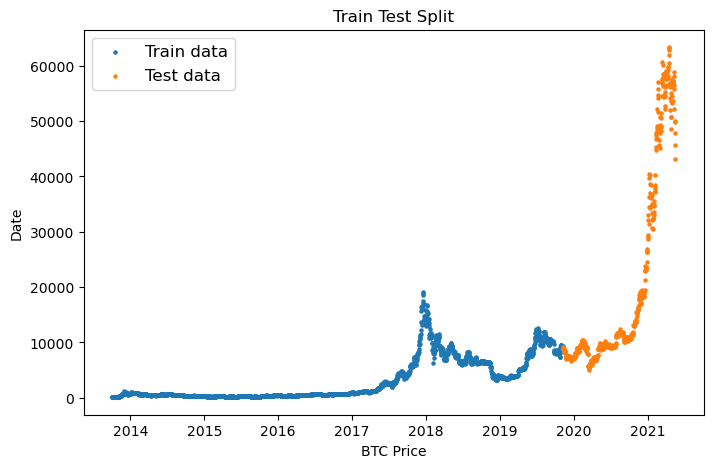

In [25]:
plot_train_vs_test(X_train, y_train, X_test, y_test, 'Train Test Split', 'Date', 'BTC Price')

We're going to be using the training set (past) to train a model to try and predict values on the test set (future).

Because the test set is an *artificial* future, we can guage how our model might perform on *actual* future data.

Is important to remember the test set is a pseudofuture and not the actual future, it is only meant to give you an indication of how the models you're building are performing. 

> 📖 **Resource:** Working with time series data can be tricky compared to other kinds of data. And there are a few pitfalls to watch out for, such as how much data to use for a test set. The article [*3 facts about time series forecasting that surprise experienced machine learning practitioners*](https://towardsdatascience.com/3-facts-about-time-series-forecasting-that-surprise-experienced-machine-learning-practitioners-69c18ee89387) talks about different things to watch out for when working with time series data.



<a name="5"></a>
## <font color='#1a5276'> <b> 5. Pre-processing </font> </b>

Since most models require different input data (e.g., due to different window sizes or horizons), we will perform the preprocessing immediately before building the model.

<a name="6"></a>
## <font color='#1a5276'> <b> 6. Modeling Experiments </font> </b>

Before we discuss what modelling experiments we're going to run, there are two terms you should be familiar with, **horizon** and **window**. 
  * **horizon** = number of timesteps to predict into future
  * **window** = number of timesteps from past used to predict **horizon**

For example, if we wanted to predict the price of Bitcoin for tomorrow (1 day in the future) using the previous week's worth of Bitcoin prices (7 days in the past), the horizon would be 1 and the window would be 7.

Now, how about those modelling experiments?

| Model Number | Model Type | Horizon size | Window size |
| ----- | ----- | ----- | ----- | 
| 0 | Naïve model (baseline) | NA | NA |
| 1 | Dense model | 1 | 7 | 
| 2 | Dense model | 1 | 30 | 
| 3 | Dense model | 7 | 30 | 
| 4 | Conv1D | 1 | 7 | 
| 5 | LSTM | 1 | 7 | 
| 6 | Ensemble (multiple models optimized on different loss functions) | 1 | 7 | 



In [26]:
# Set random seed for as reproducible results as possible
tf.random.set_seed(42)

<a name="6.0"></a>
### <font color='#1f618d'> <b> 6.0. Model 0 (Baseline): Naive Forecast </font> </b>

One of the most common baseline models for time series forecasting, the naïve model (also called the [naïve forecast](https://otexts.com/fpp3/simple-methods.html#na%C3%AFve-method)), requires no training at all.

That's because all the naïve model does is use the previous timestep value to predict the next timestep value.

The formula looks like this:

$$\hat{y}_{t} = y_{t-1}$$ 

In English: 
> The prediction at timestep `t` (y-hat) is equal to the value at timestep `t-1` (the previous timestep).


In an open system (like a stock market or crypto market), you'll often find beating the naïve forecast with *any* kind of model is quite hard.

> 🔑 **Note:** For the sake of this notebook, an **open system** is a system where inputs and outputs can freely flow, such as a market (stock or crypto). Where as, a **closed system** the inputs and outputs are contained within the system (like a poker game with your buddies, you know the buy in and you know how much the winner can get). Time series forecasting in **open systems** is generally quite poor.

In [27]:
# Create a naïve forecast
naive_forecast = y_test[:-1] # Naïve forecast equals every value excluding the last value
naive_forecast[:3], naive_forecast[-3:] # View first 3 and last 3 

(array([9226.48582088, 8794.35864452, 8798.04205463]),
 array([50032.69313676, 47885.62525472, 45604.61575361]))

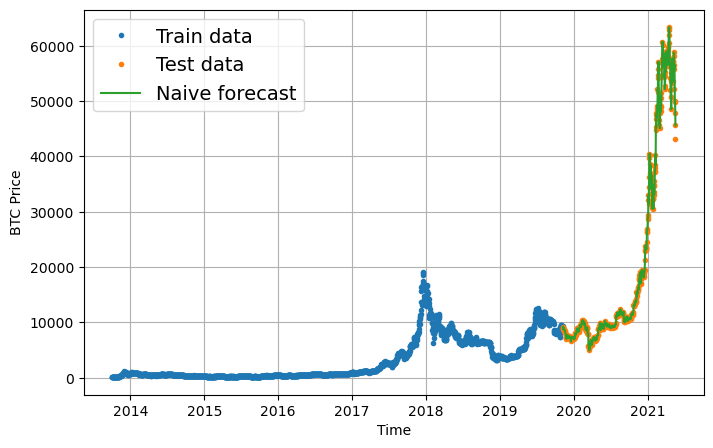

In [28]:
# Plot naive forecast
plt.figure(figsize=(8, 5))
plot_time_series(timesteps=X_train, values=y_train, label="Train data")
plot_time_series(timesteps=X_test, values=y_test, label="Test data")
plot_time_series(timesteps=X_test[1:], values=naive_forecast, format="-", label="Naive forecast");

The naive forecast looks like it's following the data well. 

Let's zoom in to take a better look.

We can do so by creating an offset value and passing it to the `start` parameter of our `plot_time_series()` function.

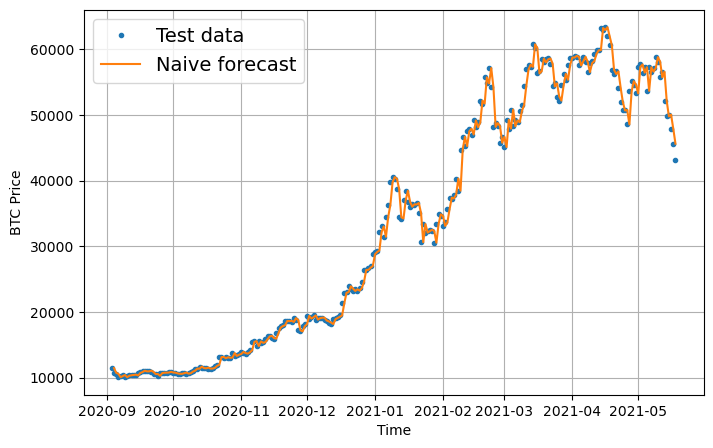

In [29]:
plt.figure(figsize=(8, 5))
offset = 300 # offset the values by 300 timesteps 
plot_time_series(timesteps=X_test, values=y_test, start=offset, label="Test data")
plot_time_series(timesteps=X_test[1:], values=naive_forecast, format="-", start=offset, label="Naive forecast");

When we zoom in we see the naïve forecast comes slightly after the test data. This makes sense because the naive forecast uses the previous timestep value to predict the next timestep value.

In [30]:
naive_results = evaluate_preds(y_true=y_test[1:],
                               y_pred=naive_forecast)
naive_results

{'mae': 567.9802,
 'mse': 1147547.0,
 'rmse': 1071.2362,
 'mape': 2.5165248,
 'mase': 0.99957}

Taking a look at the naïve forecast's MAE, it seems on average each forecast is ~$567 different than the actual Bitcoin price.

How does this compare to the average price of Bitcoin in the test dataset?

In [31]:
# Find average price of Bitcoin in test dataset
tf.reduce_mean(y_test).numpy()

20056.632963737226

Okay, looking at these two values is starting to give us an idea of how our model is performing:
* The average price of Bitcoin in the test dataset is: $20,056 (note: average may not be the best measure here, since the highest price is over 3x this value and the lowest price is over 4x lower)

* Each prediction in naive forecast is on average off by: $567

Is this enough to say it's a good model?

That's up your own interpretation. Personally, I'd prefer a model which was closer to the mark.

How about we try and build one?


<a name="6.1"></a>
### <font color='#1f618d'> <b> 6.1. Dense Model (window = 7, horizon = 1) </font> </b>

### Preparing data

In [32]:
WINDOW_SIZE = 7
HORIZON = 1

#### Windowing

In [33]:
full_windows, full_labels = make_windows(prices, window_size=G.WINDOW_SIZE, horizon=G.HORIZON)
len(full_windows), len(full_labels)

(2780, 2780)

In [34]:
# View the first 3 windows/labels
for i in range(3):
  print(f"Window: {full_windows[i]} -> Label: {full_labels[i]}")

Window: [123.65499 125.455   108.58483 118.67466 121.33866 120.65533 121.795  ] -> Label: [123.033]
Window: [125.455   108.58483 118.67466 121.33866 120.65533 121.795   123.033  ] -> Label: [124.049]
Window: [108.58483 118.67466 121.33866 120.65533 121.795   123.033   124.049  ] -> Label: [125.96116]


In [35]:
# View the last 3 windows/labels
for i in range(3):
  print(f"Window: {full_windows[i-3]} -> Label: {full_labels[i-3]}")

Window: [58788.20967893 58102.19142623 55715.54665129 56573.5554719
 52147.82118698 49764.1320816  50032.69313676] -> Label: [47885.62525472]
Window: [58102.19142623 55715.54665129 56573.5554719  52147.82118698
 49764.1320816  50032.69313676 47885.62525472] -> Label: [45604.61575361]
Window: [55715.54665129 56573.5554719  52147.82118698 49764.1320816
 50032.69313676 47885.62525472 45604.61575361] -> Label: [43144.47129086]


#### Train/Test Split

In [36]:
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(full_windows, full_labels)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(2224, 556, 2224, 556)

In [37]:
train_windows[:3], train_labels[:3]

(array([[123.65499, 125.455  , 108.58483, 118.67466, 121.33866, 120.65533,
         121.795  ],
        [125.455  , 108.58483, 118.67466, 121.33866, 120.65533, 121.795  ,
         123.033  ],
        [108.58483, 118.67466, 121.33866, 120.65533, 121.795  , 123.033  ,
         124.049  ]]),
 array([[123.033  ],
        [124.049  ],
        [125.96116]]))

In [38]:
# Check to see if same (accounting for horizon and window size)
np.array_equal(np.squeeze(train_labels[:-G.HORIZON-1]), y_train[G.WINDOW_SIZE:])

True

### Build, compile and fit the model

In [39]:
def build_compile_model_one(name, horizon=1):
    
    model = tf.keras.Sequential([
          layers.Dense(10, activation="relu"),
          layers.Dense(horizon, activation="linear") # linear activation is the same as having no activation                        
        ], name=name)
    
    model.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["mae"])
    
    return model

model_1 = build_compile_model_one("model_1_dense")    


In [40]:
# Fit model
history_1 = model_1.fit(x=train_windows, # train windows of 7 timesteps of Bitcoin prices
            y=train_labels, # horizon value of 1 (using the previous 7 timesteps to predict next day)
            epochs=50,
            verbose=0,
            batch_size=G.BATCH_SIZE,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_1.name)]) # create ModelCheckpoint callback 
                                                                          # to save best model

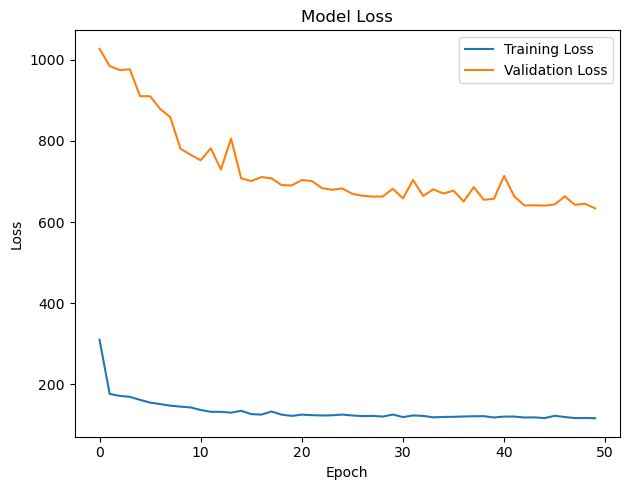

In [41]:
plot_history(history_1)

### Predictions and evaluation

In [42]:
# Evaluate model on test data
model_1.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 1ms/step - loss: 633.4906 - mae: 633.4906


[633.4906005859375, 633.4906005859375]

In [43]:
history_1.history['val_loss'][-1]

633.4906005859375

You'll notice the model achieves the same `val_loss` (in this case, this is MAE) as the last epoch.

But if we load in the version of `model_1` which was saved to file using the `ModelCheckpoint` callback, we should see an improvement in results.

In [44]:
# Load in saved best performing model_1 and evaluate on test data
model_1 = tf.keras.models.load_model("model_experiments/model_1_dense")
model_1.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 1ms/step - loss: 633.4906 - mae: 633.4906


[633.4906005859375, 633.4906005859375]

Much better! Due to the fluctuating performance of the model during training, loading back in the best performing model see's a sizeable improvement in MAE.

#### Making predictions

#### Wrong way

In [45]:
# Make predictions using model_1 on the test dataset and view the results
model_1_preds = make_preds(model_1, test_windows)
len(model_1_preds), model_1_preds[:2]

18/18 [==============================] - 0s 905us/step


(556,
 <tf.Tensor: shape=(2,), dtype=float32, numpy=array([8964.343, 8732.17 ], dtype=float32)>)

> 🔑 **Note:** With these outputs, our model isn't *forecasting* yet. It's only making predictions on the test dataset. Forecasting would involve a model making predictions into the future, however, the test dataset is only a pseudofuture.

Excellent! Now we've got some prediction values, let's use the `evaluate_preds()` we created before to compare them to the ground truth.

In [46]:
# Evaluate preds
model_1_results = evaluate_preds(y_true=tf.squeeze(test_labels), # reduce to right shape
                                 y_pred=model_1_preds)
model_1_results

{'mae': 633.4906,
 'mse': 1374580.8,
 'rmse': 1172.4252,
 'mape': 2.862333,
 'mase': 1.1128675}

Little worse than Naive results.

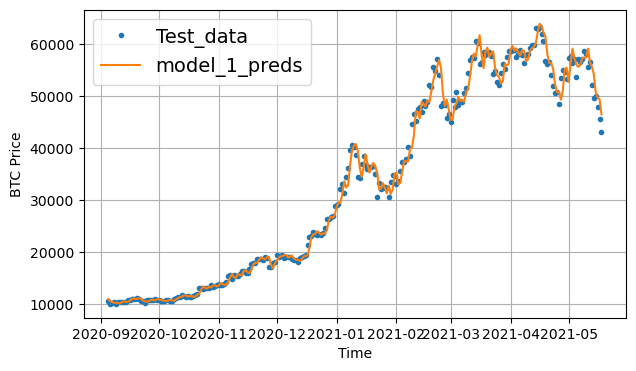

In [47]:
plot_comparisson(X_test[-len(test_windows):], test_labels[:, 0], model_1_preds, 'model_1_preds', 
                 figsize=(7, 4))

What's wrong with these predictions?

As mentioned before, they're on the test dataset. So they're not actual forecasts.


#### Right way to forecast (but without re-training the model)

In [54]:
future_forecast = make_future_forecast(model=model_1,
                                       initial_window=test_windows[0], # first test window
                                       into_future=len(test_labels),
                                       window_size=G.WINDOW_SIZE)

In [55]:
type(future_forecast), model_1_preds.shape

(numpy.ndarray, TensorShape([556]))

In [56]:
model_1_results = evaluate_preds(y_true=tf.squeeze(test_labels), # reduce to right shape
                                 y_pred=future_forecast)
model_1_results

{'mae': 8816.565,
 'mse': 175112770.0,
 'rmse': 13233.019,
 'mape': 41.63315,
 'mase': 15.488263}

Terrible! However, we must keep in mind that we are looking 556 steps ahead (the length of the validation set), and at each step, we are accumulating previous errors. In a real-world problem, we wouldn’t look so far ahead; in this case, we might want to look one month ahead and then keep retraining the model.

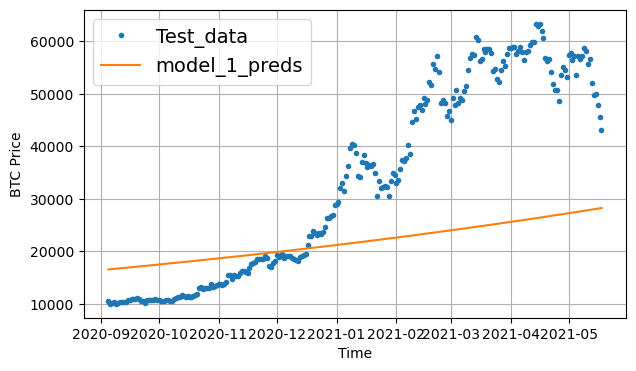

In [57]:
plot_comparisson(X_test[-len(test_windows):], test_labels[:, 0], future_forecast, 'model_1_preds', 
                 figsize=(7, 4))

<a name="6.2"></a>
### <font color='#1f618d'> <b> 6.2. Dense Model (window = 30, horizon = 1) </font> </b>

We need to prepare the data for this model, which is different from the previous model because the window size changes.

### Preparing data

In [58]:
# hyperparameters
HORIZON = 1 # predict one step at a time
WINDOW_SIZE = 30 # use 30 timesteps in the past

In [59]:
# Make windowed data with appropriate horizon and window sizes
full_windows, full_labels = make_windows(prices, window_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows), len(full_labels)

(2757, 2757)

In [60]:
# Make train and testing windows
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(windows=full_windows, labels=full_labels)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(2205, 552, 2205, 552)

In [61]:
train_windows.shape, train_labels.shape, test_windows.shape, test_labels.shape

((2205, 30), (2205, 1), (552, 30), (552, 1))

### Build, compile, fit and evaluation of the model

In [62]:
def build_compile_model_2(name, horizon):
    
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(10, activation='relu'),
        tf.keras.layers.Dense(horizon)
    ], name=name)
    
    model.compile(loss='mae',
                  optimizer=tf.keras.optimizers.Adam())
    
    return model

model_2 = build_compile_model_2('model_2_dense', HORIZON)


In [63]:
# fit
history_2 = model_2.fit(train_windows,
            train_labels,
            epochs=100,
            batch_size=128,
            verbose=0,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_2.name)])

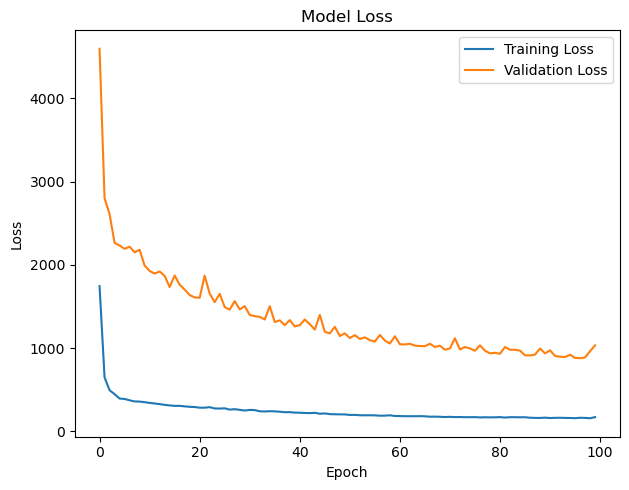

In [64]:
plot_history(history_2)

### Predictions and evaluation

In [65]:
# Evaluate model on test data
model_2.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 1ms/step - loss: 1034.1405


1034.1405029296875

In [66]:
# Load in saved best performing model_2 and evaluate on test data
model_2 = tf.keras.models.load_model("model_experiments/model_2_dense")
model_2.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 987us/step - loss: 879.3678


879.3677978515625

#### Wrong way to forecast

18/18 [==============================] - 0s 941us/step
{'mae': 879.368, 'mse': 2527255.8, 'rmse': 1589.7345, 'mape': 4.1394873, 'mase': 1.5371437}


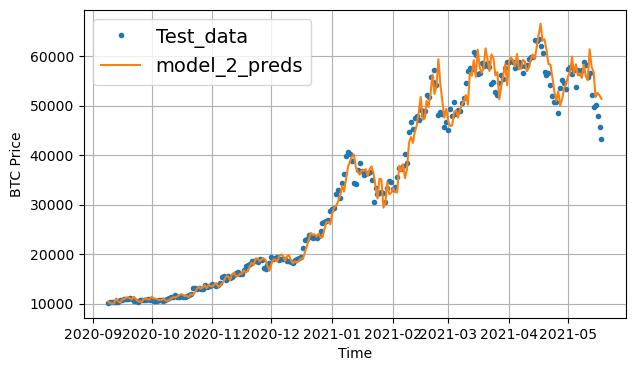

In [67]:
model_2_preds = make_preds(model_2, test_windows)


model_2_results = evaluate_preds(y_true=tf.squeeze(test_labels),
                                 y_pred=model_2_preds)

print(model_2_results)

plot_comparisson(X_test[-len(test_windows):], test_labels[:, 0], model_2_preds, 'model_2_preds', 
                 figsize=(7, 4))


#### Right way to forecast

{'mae': 104895.9, 'mse': 72587140000.0, 'rmse': 269420.0, 'mape': 324.53156, 'mase': 183.35904}


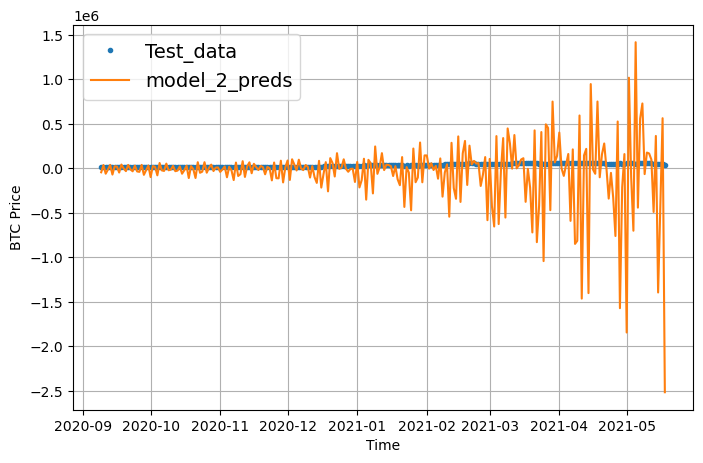

In [68]:
# right way
future_forecast_2 = make_future_forecast(model=model_2,
                                       initial_window=test_windows[0],
                                       into_future=len(test_labels),
                                       window_size=WINDOW_SIZE)
                                       
model_2_results = evaluate_preds(y_true=tf.squeeze(test_labels),
                                 y_pred=future_forecast_2)

print(model_2_results)

plot_comparisson(X_test[-len(test_windows):], test_labels[:, 0], future_forecast_2, 
                 'model_2_preds', figsize=(8, 5))

<a name="6.3"></a>
### <font color='#1f618d'> <b> 6.3. Dense Model (window = 30, horizon = 7) </font> </b>

### Preparing data

In [69]:
HORIZON = 7
WINDOW_SIZE = 30

In [70]:
full_windows, full_labels = make_windows(prices, window_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows), len(full_labels)

(2751, 2751)

In [71]:
full_windows[-1], full_labels[-1], full_windows[-1].shape, full_labels[-1].shape

(array([59822.90167743, 59853.19724227, 63223.88439079, 62926.5571759 ,
        63346.78903511, 61965.7825981 , 60574.44472823, 56850.83016569,
        56224.10158771, 56608.76974839, 54144.42747606, 51965.05955941,
        50669.14438218, 50733.76950364, 48542.95220298, 53558.70784462,
        55123.86198142, 54591.51532554, 53260.29534115, 57302.64642408,
        57677.9752219 , 56427.04312502, 57255.30683756, 53658.84312082,
        57252.7021845 , 56583.84987917, 57107.12067189, 58788.20967893,
        58102.19142623, 55715.54665129]),
 array([56573.5554719 , 52147.82118698, 49764.1320816 , 50032.69313676,
        47885.62525472, 45604.61575361, 43144.47129086]),
 (30,),
 (7,))

In [72]:
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(windows=full_windows, labels=full_labels, test_split=0.2)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(2200, 551, 2200, 551)

### Build, compile and fit the model

In [73]:
def build_compile_model_3(name, horizon):
    
    model = tf.keras.Sequential([
      layers.Dense(256, activation="relu"),
      layers.Dense(128, activation="relu"),
      layers.Dense(horizon)
    ], name=name)

    model.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam())
    
    return model


model_3 = build_compile_model_3('model_3_dense', HORIZON)


In [74]:
history_3 = model_3.fit(train_windows,
            train_labels,
            batch_size=32,
            epochs=100,
            verbose=0,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_3.name)])

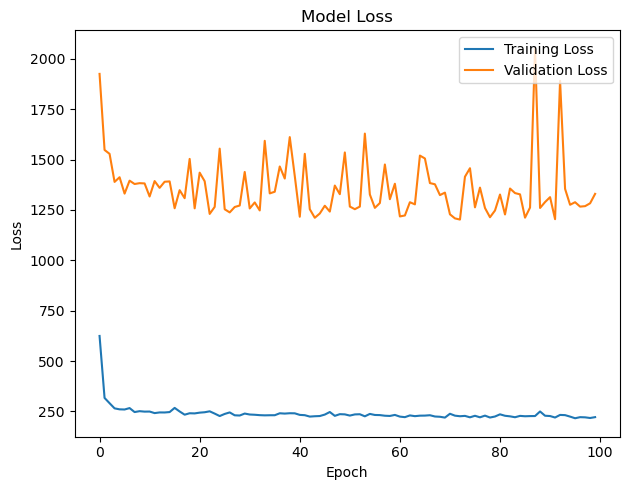

In [75]:
plot_history(history_3)

### Predictions and evaluation

In [76]:
# How did our model with a larger window size and horizon go?
model_3.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 1ms/step - loss: 1329.8582


1329.858154296875

In [77]:
# Load in best version of model_3 and evaluate
model_3 = tf.keras.models.load_model("model_experiments/model_3_dense/")
model_3.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 1ms/step - loss: 1202.3438


1202.34375

In this case, the error will be higher because we're predicting 7 steps at a time. 

This makes sense though because the further you try and predict, the larger your error will be (think of trying to predict the weather 7 days in advance).

Let's make predictions with our model using the `make_preds()` function and evaluate them using the `evaluate_preds()` function.

#### Wrong way

In [78]:
# The predictions are going to be 7 steps at a time (this is the HORIZON size)
model_3_preds = make_preds(model_3,
                           input_data=test_windows)
model_3_preds[:3], model_3_preds.shape

18/18 [==============================] - 0s 1ms/step


(<tf.Tensor: shape=(3, 7), dtype=float32, numpy=
 array([[9295.393, 9436.908, 9515.02 , 9616.03 , 9665.045, 9457.769,
         9561.627],
        [8927.538, 9035.033, 9121.188, 9257.005, 9298.298, 9096.042,
         9149.491],
        [8776.108, 8909.992, 8957.802, 9134.564, 9166.488, 8950.062,
         9023.464]], dtype=float32)>,
 TensorShape([551, 7]))

In [79]:
# Calculate model_3 results - these are going to be multi-dimensional because
# we're trying to predict more than one step at a time.
model_3_results = evaluate_preds(y_true=tf.squeeze(test_labels),
                                 y_pred=model_3_preds)
model_3_results

{'mae': array([  713.6123  ,   388.30176 ,   371.23257 ,   539.8952  ,
          514.9517  ,   538.9014  ,   572.9566  ,   546.2252  ,
          502.24838 ,   608.98425 ,   797.59924 ,   855.09265 ,
          955.38525 ,   976.9505  ,   715.16125 ,   316.34906 ,
          257.85623 ,   157.58287 ,   132.27385 ,   149.64928 ,
          261.13715 ,   273.06033 ,   431.87125 ,   413.6849  ,
          191.77121 ,   130.28654 ,    72.30085 ,    99.26409 ,
          136.58469 ,   240.47014 ,   372.1437  ,   448.40375 ,
          334.6107  ,   358.75504 ,   290.2583  ,   333.68832 ,
          329.88763 ,   243.33371 ,   243.4467  ,   197.2463  ,
          425.1199  ,    67.51088 ,    93.58831 ,    67.85198 ,
          174.94133 ,   188.08621 ,   122.73054 ,   135.47615 ,
           73.79457 ,   112.23431 ,   131.94762 ,   189.14146 ,
          235.35115 ,   223.89272 ,   265.33908 ,   327.6645  ,
          491.96674 ,   506.15903 ,   399.9929  ,   460.2341  ,
          333.1562  ,   199.44197

You'll notice the outputs for `model_3_results` are multi-dimensional. 

This is because the predictions are getting evaluated across the `HORIZON` timesteps (7 predictions at a time).

Because of this we are going to use are generalized evaluation function.

In [80]:
# Get model_3 results aggregated to single values
model_3_results = evaluate_preds_generalized(y_true=tf.squeeze(test_labels),
                                 y_pred=model_3_preds)
model_3_results

{'mae': 1202.3438,
 'mse': 5213237.0,
 'rmse': 1390.895,
 'mape': 5.4819946,
 'mase': 2.1395032}

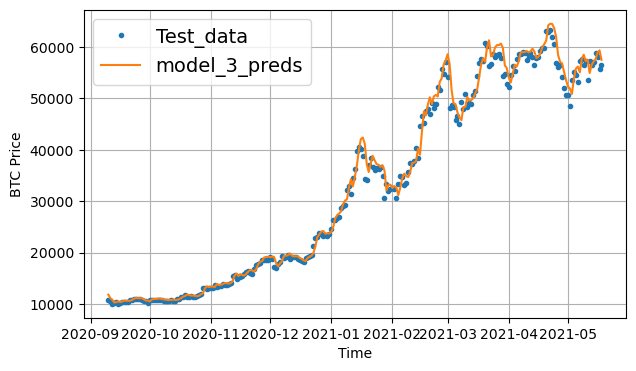

In [81]:
offset = 300
plt.figure(figsize=(7, 4))
# Plot model_3_preds by aggregating them (note: this condenses information so the preds will look fruther ahead than the test data)
plot_time_series(timesteps=X_test[-len(test_windows):], 
                 values=test_labels[:, 0], 
                 start=offset, 
                 label="Test_data")
plot_time_series(timesteps=X_test[-len(test_windows):], 
                 values=tf.reduce_mean(model_3_preds, axis=1), 
                 format="-",
                 start=offset, 
                 label="model_3_preds")

#### Right way to make predictions

In [82]:
# predictions, right way
future_forecast_3 = make_future_forecast(model=model_3,
                                       initial_window=test_windows[0],
                                       into_future=len(test_labels),
                                       window_size=WINDOW_SIZE,
                                       verbose=False)

model_3_results = evaluate_preds_generalized(y_true=tf.squeeze(test_labels),
                                 y_pred=future_forecast_3)

print(model_3_results)

{'mae': 8321.042, 'mse': 88839930.0, 'rmse': 8413.535, 'mape': 63.339497, 'mase': 14.806828}


MSE is huge!!

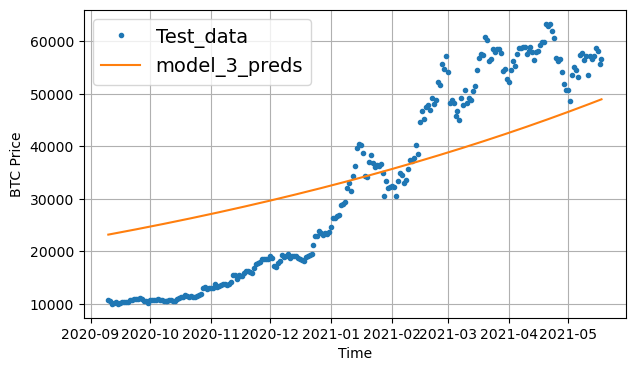

In [83]:
offset = 300
plt.figure(figsize=(7, 4))
# Plot model_3_preds by aggregating them (note: this condenses information so the preds will look fruther ahead than the test data)
plot_time_series(timesteps=X_test[-len(test_windows):], 
                 values=test_labels[:, 0], 
                 start=offset, 
                 label="Test_data")
plot_time_series(timesteps=X_test[-len(test_windows):], 
                 values=tf.reduce_mean(future_forecast_3, axis=1), 
                 format="-",
                 start=offset, 
                 label="model_3_preds")

<a name="6.4"></a>
### <font color='#1f618d'> <b> 6.4. Conv1D </font> </b>

Conv1D models can be used for seq2seq (sequence to sequence) problems.

In our case, the input sequence is the previous 7 days of Bitcoin price data and the output is the next day (in seq2seq terms this is called a many to one problem).

<img src="images/CONV1D.png"/>


*Framing Bitcoin forecasting in seq2seq (sequence to sequence) terms. Using a window size greater than 1 and a horizon of one results in a many to one problem. Using a window size of >1 and a horizon of >1 results in a many to many problem.

Before we build a Conv1D model, let's recreate our datasets.

### Preparing data

In [84]:
HORIZON = 1 # predict next day
WINDOW_SIZE = 7 # use previous week worth of data

In [85]:
# Create windowed dataset
full_windows, full_labels = make_windows(prices, window_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows), len(full_labels)

(2780, 2780)

In [86]:
# Create train/test splits
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(full_windows, full_labels)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(2224, 556, 2224, 556)

Now, since we're going to be using Conv1D layers, we need to make sure our input shapes are correct.

The Conv1D layer in TensorFlow takes an input of: (batch_size, timesteps, input_dim).

In our case:

- The batch_size is handled automatically.

- timesteps = WINDOW_SIZE - our model will view WINDOW_SIZE (one week) worth of past data at a time.

- input_dim = num_features - the number of features in each timestep (e.g., temperature, humidity, etc.). In our case will be 1.

Currently, our data has the correct timesteps dimension, but we need to ensure it includes the appropriate input_dim.



In [87]:
# Check data sample shapes
train_windows[0].shape # returns (WINDOW_SIZE, )

(7,)

To fix this, we could adjust the shape of all of our `train_windows` or we could use a [`tf.keras.layers.Lamdba`](https://keras.io/api/layers/core_layers/lambda/) (called a Lambda layer) to do this for us in our model.

The Lambda layer wraps a function into a layer which can be used with a model.

In [88]:
# Before we pass our data to the Conv1D layer, we have to reshape it in order to make sure it works
x = tf.constant(train_windows[0])
expand_dims_layer = layers.Lambda(lambda x: tf.expand_dims(x, axis=1)) # add an extra dimension
print(f"Original shape: {x.shape}") # (WINDOW_SIZE)
print(f"Expanded shape: {expand_dims_layer(x).shape}") # (WINDOW_SIZE, input_dim) 
print(f"Original values with expanded shape:\n {expand_dims_layer(x)}")

Original shape: (7,)
Expanded shape: (7, 1)
Original values with expanded shape:
 [[123.65499]
 [125.455  ]
 [108.58483]
 [118.67466]
 [121.33866]
 [120.65533]
 [121.795  ]]


### Build, compile and fit the model

In [89]:
def build_compile_model_4(name, horizon):
    # Create model
    model = tf.keras.Sequential([
      # Create Lambda layer to reshape inputs, without this layer, the model will error
      layers.Lambda(lambda x: tf.expand_dims(x, axis=1)), # resize the inputs to adjust for window size / Conv1D 3D input requirements
      layers.Conv1D(filters=128, kernel_size=5, padding="causal", activation="relu"),
      layers.Dense(horizon)
    ], name=name)

    # Compile model
    model.compile(loss="mae",
                    optimizer=tf.keras.optimizers.Adam())
    
    return model
    
    
model_4 = build_compile_model_4('model_4_conv1D', HORIZON)
    

In [90]:
# fit
history_4 = model_4.fit(train_windows,
            train_labels,
            batch_size=32, 
            epochs=100,
            verbose=0,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_4.name)])

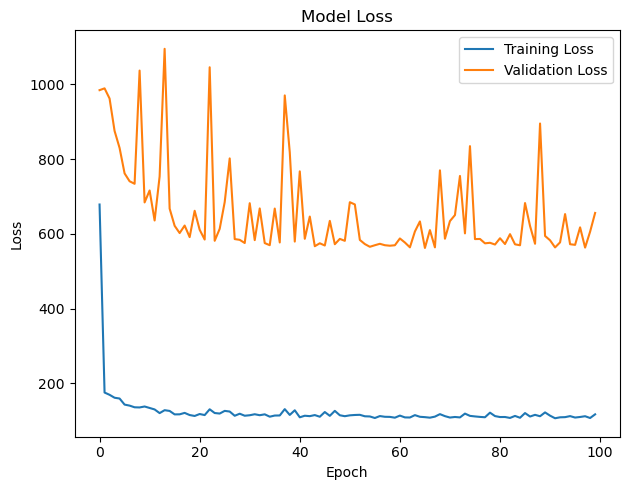

In [91]:
plot_history(history_4)

### Predictions and evaluation

In [92]:
# Load in best performing Conv1D model and evaluate it on the test data
model_4 = tf.keras.models.load_model("model_experiments/model_4_conv1D")
model_4.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 1ms/step - loss: 562.4227


562.4227294921875

#### Wrong way to forecast

In [93]:
# Make predictions (wrong way)
model_4_preds = make_preds(model_4, test_windows)
model_4_preds[:10]

18/18 [==============================] - 0s 915us/step


<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([8846.564, 8774.198, 9039.843, 8786.474, 8734.609, 8734.772,
       8682.239, 8523.944, 8454.38 , 8530.899], dtype=float32)>

In [94]:
# Evaluate predictions
model_4_results = evaluate_preds(y_true=tf.squeeze(test_labels),
                                 y_pred=model_4_preds)
model_4_results

{'mae': 562.42267,
 'mse': 1149565.5,
 'rmse': 1072.178,
 'mape': 2.5135362,
 'mase': 0.98802084}

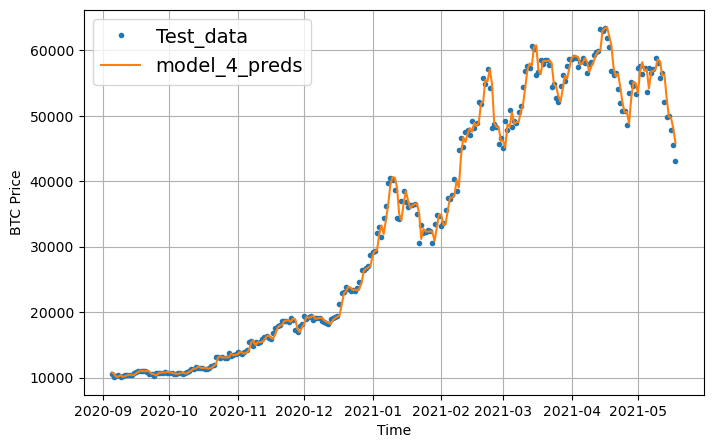

In [95]:
plot_comparisson(X_test[-len(test_windows):], test_labels[:, 0], model_4_preds, 'model_4_preds', 
                 figsize=(8, 5))

#### Right way to forecast

{'mae': 10340.598, 'mse': 338054620.0, 'rmse': 18386.262, 'mape': 32.115234, 'mase': 18.165565}


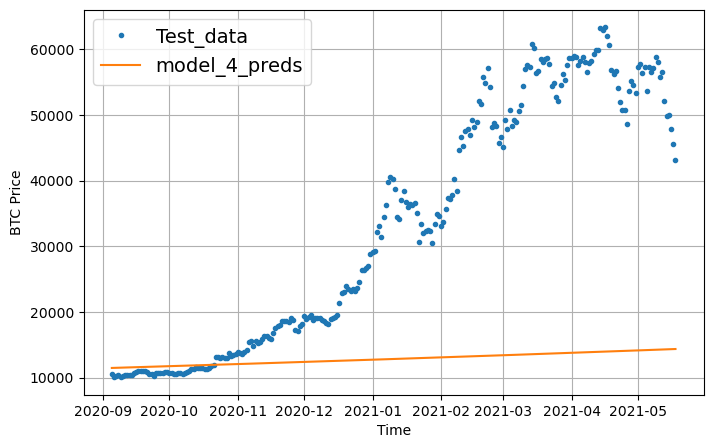

In [96]:
# predictions, right way
future_forecast_4 = make_future_forecast(model=model_4,
                                       initial_window=test_windows[0],
                                       into_future=len(test_labels),
                                       window_size=WINDOW_SIZE,
                                       verbose=False)

model_4_results = evaluate_preds(y_true=tf.squeeze(test_labels),
                                 y_pred=future_forecast_4)


print(model_4_results)


plot_comparisson(X_test[-len(test_windows):], test_labels[:, 0], future_forecast_4, 'model_4_preds', 
                 figsize=(8, 5))


<a name="6.5"></a>
### <font color='#1f618d'> <b> 6.5. LSTM </font> </b>

### Preparing data

In [97]:
HORIZON = 1 # predict next day
WINDOW_SIZE = 7 # use previous week worth of data

In [98]:
# Create windowed dataset
full_windows, full_labels = make_windows(prices, window_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows), len(full_labels)

(2780, 2780)

In [99]:
# Create train/test splits
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(full_windows, full_labels)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(2224, 556, 2224, 556)

### Build, compile and fit the model

In [100]:
def build_compile_model_5(name, window_size=WINDOW_SIZE, horizon=HORIZON):
    inputs = layers.Input(shape=(window_size))
    x = layers.Lambda(lambda x: tf.expand_dims(x, axis=1))(inputs)
        # expand input dimension to be compatible with LSTM
    x = layers.LSTM(128, activation='relu')(x)
    output = layers.Dense(horizon)(x)
    model = tf.keras.Model(inputs=inputs, outputs=output, name=name)
    
    model.compile(loss='mae',
                 optimizer=tf.keras.optimizers.Adam())
    
    return model


model_5 = build_compile_model_5('model_5_lstm')

In [101]:
# fit
history_5 = model_5.fit(train_windows,
            train_labels,
            epochs=100,
            verbose=0,
            batch_size=32,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_5.name)])

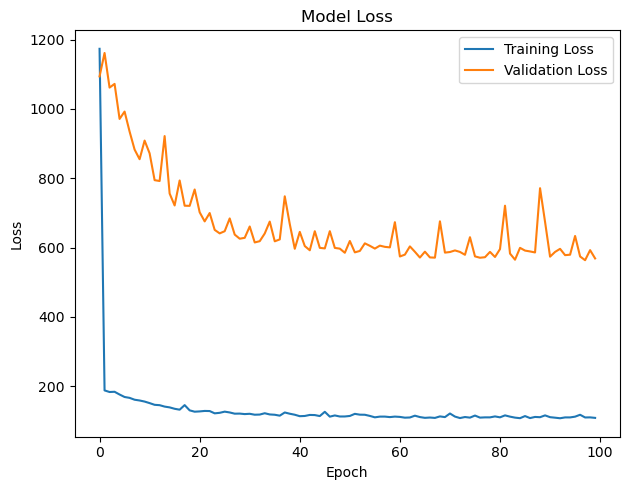

In [102]:
plot_history(history_5)

### Predictions and evaluation

In [103]:
# Load in best performing Conv1D model and evaluate it on the test data
model_5 = tf.keras.models.load_model("model_experiments/model_5_lstm")
model_5.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 2ms/step - loss: 563.6207


563.6206665039062

#### Wrong way to forecast

18/18 [==============================] - 0s 2ms/step
{'mae': 563.62067, 'mse': 1157691.8, 'rmse': 1075.9608, 'mape': 2.527107, 'mase': 0.9901254}


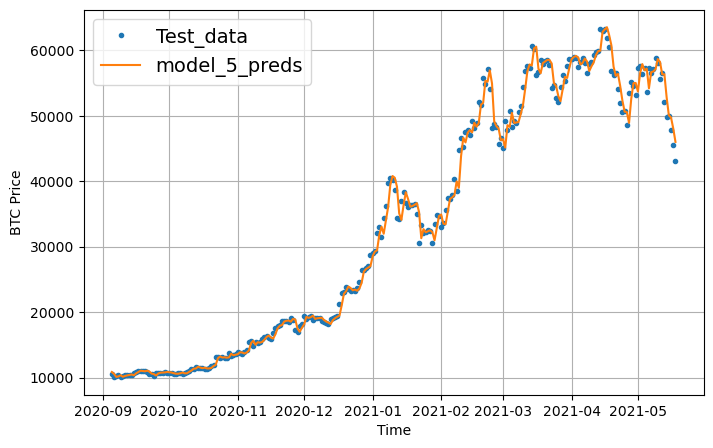

In [104]:
# Make predictions (wrong way)
model_5_preds = make_preds(model_5, test_windows)

# Evaluate predictions
model_5_results = evaluate_preds(y_true=tf.squeeze(test_labels),
                                 y_pred=model_5_preds)

print(model_5_results)

# plot
plot_comparisson(X_test[-len(test_windows):], test_labels[:, 0], model_5_preds, 'model_5_preds', 
                 figsize=(8, 5))

#### Right way to forecast

{'mae': 9770.627, 'mse': 281242200.0, 'rmse': 16770.277, 'mape': 34.343807, 'mase': 17.164286}


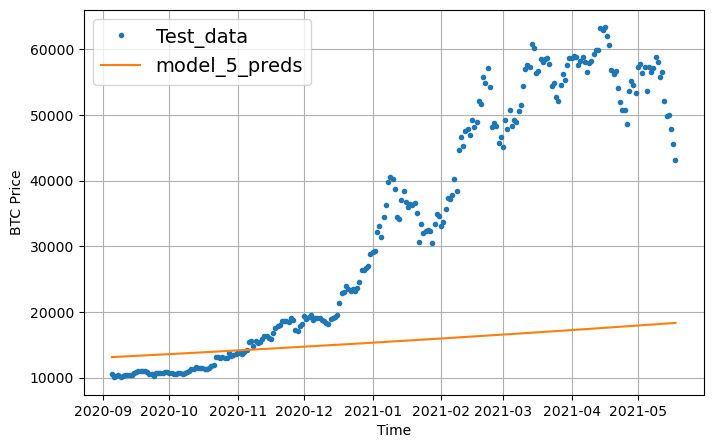

In [105]:
# predictions
future_forecast_5 = make_future_forecast(model=model_5,
                                       initial_window=test_windows[0],
                                       into_future=len(test_labels),
                                       window_size=WINDOW_SIZE,
                                       verbose=False)

# evaluation
model_5_results = evaluate_preds(y_true=tf.squeeze(test_labels),
                                 y_pred=future_forecast_5)

print(model_5_results)

# plot
plot_comparisson(X_test[-len(test_windows):], test_labels[:, 0], future_forecast_5, 'model_5_preds', 
                 figsize=(8, 5))


<a name="6.6"></a>
### <font color='#1f618d'> <b> 6.6. Ensemble </font> </b>


Our next experiment is creating an [**ensemble** of models](https://en.wikipedia.org/wiki/Ensemble_learning).

An **ensemble** involves training and combining multiple different models on the same problem.

For example, in the N-BEATS paper, they trained an ensemble of models (180 in total, see [section 3.4](https://arxiv.org/pdf/1905.10437.pdf)) to achieve the results they did using a combination of:
  * Different loss functions (sMAPE, MASE and MAPE)
  * Different window sizes (2 x horizon, 3 x horizon, 4 x horizon...)

The benefit of ensembling models is you get the "decision of the crowd effect". Rather than relying on a single model's predictions, you can [take the average or median of many different models](https://en.wikipedia.org/wiki/Ensemble_forecasting).

The keyword being: different.

It wouldn't make sense to train the same model 10 times on the same data and then average the predictions.

Fortunately, due to their random initialization, even deep learning models with the same architecture can produce different results. 

What I mean by this is each time you create a deep learning model, it starts with random patterns (weights & biases) and then it adjusts these random patterns to better suit the dataset it's being trained on. 

However, the process it adjusts these patterns is often a form of guided randomness as well (the SGD optimizer stands for stochastic or random gradient descent).

To create our ensemble models we're going to be using a combination of: 
* Different loss functions (MAE, MSE, MAPE)
* Randomly initialized models 

Essentially, we'll be creating a suite of different models all attempting to model the same data.


We'll start by creating a function to produce a list of different models trained with different loss functions. Each layer in the ensemble models will be initialized with a random normal [(Gaussian) distribution](https://en.wikipedia.org/wiki/Normal_distribution) using [He normal initialization](https://www.tensorflow.org/api_docs/python/tf/keras/initializers/HeNormal), this'll help estimating the prediction intervals later on.


### Preparing data

In [108]:
HORIZON = 1
WINDOW_SIZE = 7

In [109]:
full_windows, full_labels = make_windows(prices, window_size=WINDOW_SIZE, horizon=HORIZON)
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(full_windows, full_labels)

### Creating the ensemble

In [112]:
def get_ensemble_models(horizon=HORIZON, 
                        train_windows=train_windows,
                        test_windows=test_windows,
                        train_labels=train_labels,
                        test_labels=test_labels,
                        num_iter=10, 
                        num_epochs=100, 
                        loss_fns=["mae", "mse", "mape"]):
  """
  Returns a list of num_iter models each trained on MAE, MSE and MAPE loss.

  For example, if num_iter=10, a list of 30 trained models will be returned:
  10 * len(["mae", "mse", "mape"]).
  """
  # Make empty list for trained ensemble models
  ensemble_models = []

  # Create num_iter number of models per loss function
  for i in range(num_iter):
    # Build and fit a new model with a different loss function
    for loss_function in loss_fns:
      print(f"Optimizing model by reducing: {loss_function} for {num_epochs} epochs, model number: {i}")

      # Construct a simple model (similar to model_1)
      model = tf.keras.Sequential([
        # Initialize layers with normal (Gaussian) distribution so we can use the models for prediction
        # interval estimation later: https://www.tensorflow.org/api_docs/python/tf/keras/initializers/HeNormal
        layers.Dense(128, kernel_initializer="he_normal", activation="relu"), 
        layers.Dense(128, kernel_initializer="he_normal", activation="relu"),
        layers.Dense(HORIZON)                                 
      ])

      # Compile simple model with current loss function
      model.compile(loss=loss_function,
                    optimizer=tf.keras.optimizers.Adam(),
                    metrics=["mae", "mse"])
      
      # Fit model
      model.fit(train_windows,
                train_labels,
                epochs=num_epochs,
                verbose=0,
                validation_data=(test_windows, test_labels),
                # Add callbacks to prevent training from going/stalling for too long
                callbacks=[tf.keras.callbacks.EarlyStopping(monitor="val_loss",
                                                            patience=200,
                                                            restore_best_weights=True),
                           tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",
                                                                patience=100,
                                                                verbose=1)])
      
      # Append fitted model to list of ensemble models
      ensemble_models.append(model)
    

  return ensemble_models # return list of trained models

Ensemble model creator function created!

Let's try it out by running `num_iter=5` runs for 100 epochs. This will result in 15 total models (5 for each different loss function).

Of course, these numbers could be tweaked to create more models trained for longer. 

> 🔑 **Note:** With ensembles, you'll generally find more total models means better performance. However, this comes with the tradeoff of having to train more models (longer training time) and make predictions with more models (longer prediction time).

In [114]:
%%time
# Get list of trained ensemble models
ensemble_models = get_ensemble_models(num_iter=5,
                                      num_epochs=100)

Optimizing model by reducing: mae for 100 epochs, model number: 0
Optimizing model by reducing: mse for 100 epochs, model number: 0
Optimizing model by reducing: mape for 100 epochs, model number: 0
Optimizing model by reducing: mae for 100 epochs, model number: 1
Optimizing model by reducing: mse for 100 epochs, model number: 1
Optimizing model by reducing: mape for 100 epochs, model number: 1
Optimizing model by reducing: mae for 100 epochs, model number: 2
Optimizing model by reducing: mse for 100 epochs, model number: 2
Optimizing model by reducing: mape for 100 epochs, model number: 2
Optimizing model by reducing: mae for 100 epochs, model number: 3
Optimizing model by reducing: mse for 100 epochs, model number: 3
Optimizing model by reducing: mape for 100 epochs, model number: 3
Optimizing model by reducing: mae for 100 epochs, model number: 4
Optimizing model by reducing: mse for 100 epochs, model number: 4
Optimizing model by reducing: mape for 100 epochs, model number: 4
CPU t

### Making predictions with an ensemble

#### Wrong way

In [120]:
# Create a function which uses a list of trained models to make and return a list of predictions
def make_ensemble_preds(ensemble_models, data):
  ensemble_preds = []
  for model in ensemble_models:
    preds = model.predict(data, verbose=0) # make predictions with current ensemble model
    ensemble_preds.append(preds)
  return tf.constant(tf.squeeze(ensemble_preds))

In [123]:
# Create a list of ensemble predictions
ensemble_preds = make_ensemble_preds(ensemble_models=ensemble_models,
                                     data=test_windows)

ensemble_preds.shape

TensorShape([15, 556])

Now we've got a set of ensemble predictions, we can evaluate them against the ground truth values.

However, since we've trained 15 models, there's going to be 15 sets of predictions. Rather than comparing every set of predictions to the ground truth, let's take the mean.

In [142]:
# Evaluate ensemble model(s) predictions
ensemble_results = evaluate_preds(y_true=test_labels[:,0],
                                  y_pred=np.median(ensemble_preds, axis=0)) 
                                        # take the median across all ensemble predictions
ensemble_results

{'mae': 599.4648,
 'mse': 1204459.0,
 'rmse': 1097.4785,
 'mape': 2.7689624,
 'mase': 1.0530936}

#### Right way

In [135]:
def make_ensemble_preds_2(ensemble_models, num_pred, initial_window, window_size=WINDOW_SIZE):
    ensemble_preds = []
    for model in ensemble_models:
        preds = make_future_forecast(model=model,
                                       initial_window=initial_window,
                                       into_future=num_pred,
                                       window_size=WINDOW_SIZE,
                                       verbose=False)
        ensemble_preds.append(preds)
    return tf.constant(tf.squeeze(ensemble_preds))

In [136]:
model_6_preds = make_ensemble_preds_2(ensemble_models, len(test_labels), test_windows[0])

In [141]:
ensemble_results = evaluate_preds(y_true=test_labels[:,0],
                                  y_pred=np.median(model_6_preds, axis=0))
ensemble_results

{'mae': 18700.412,
 'mse': 691564500.0,
 'rmse': 26297.613,
 'mape': 82.987175,
 'mase': 32.851444}

<a name="6.7"></a>
### <font color='#1f618d'> <b> 6.7. Comparing results </font> </b>

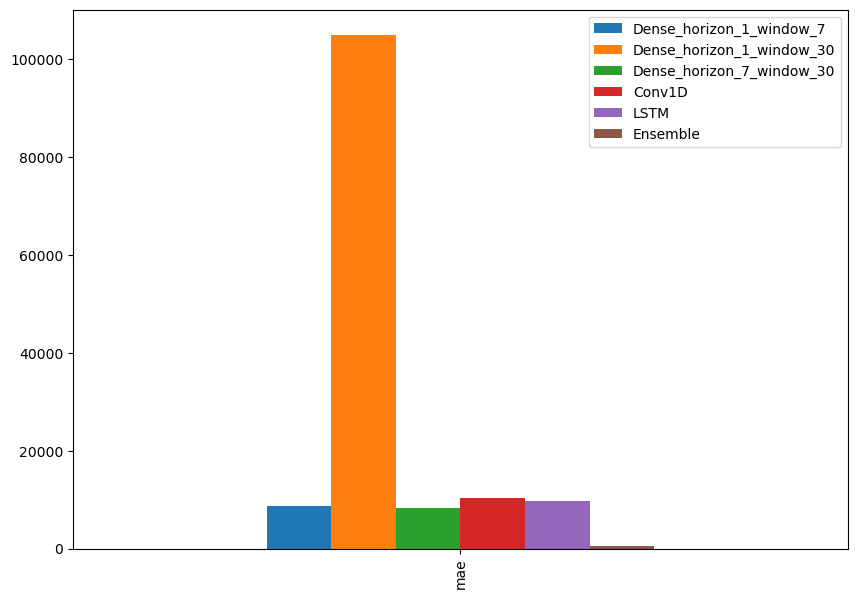

In [150]:
pd.DataFrame({"Dense_horizon_1_window_7": model_1_results["mae"], 
              "Dense_horizon_1_window_30": model_2_results["mae"], 
              "Dense_horizon_7_window_30": model_3_results["mae"],
              "Conv1D": model_4_results["mae"],
              "LSTM": model_5_results["mae"],
              "Ensemble": ensemble_results["mae"],
             }, index=["mae"]).plot(figsize=(10, 7), kind="bar");

We achieved the best results with the ensemble.

<a name="References"></a>
## <font color='#1a5276'> <b> 7. References </font> </b>

[DeepLearning.AI TensorFlow Developer Professional Certificate](https://www.coursera.org/learn/tensorflow-sequences-time-series-and-prediction?specialization=tensorflow-in-practice)

[TensorFlow for Deep Learning Bootcamp](https://www.udemy.com/course/tensorflow-developer-certificate-machine-learning-zero-to-mastery/?couponCode=MTST7102224B2)